# CNN MFCC - With Patient

Author: Jake Dumbauld <br>
Contact: jacobmilodumbauld@gmail.com<br>
Date: 3.15.22

In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import keras_tuner as kt

In [2]:
import random as python_random

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

#not sure if the below are necessary - leaving in to perhaps un-comment later.
%env PYTHONHASHSEED=0
%env CUDA_VISIBLE_DEVICES=""

env: PYTHONHASHSEED=0
env: CUDA_VISIBLE_DEVICES=""


## Helper Functions

### Model Loss

In [3]:
def graph_model_loss(title, history):
    """
    Description:
    Graphs training vs validation loss over epochs for a given model. 
    
    History: tensorflow.python.keras.callbacks.History object
    Title: str
    """ 
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title,size=24)
    plt.ylabel('Loss',size=16)
    plt.xlabel('Epoch',size=16)
    plt.legend(['Train', 'Validation'])
    plt.show()

### Train/Test Acc Printout

In [4]:
def evaluate_model(model, history):
    """
    Description:
    Outputs model train & test accuracies for currently defined train and test set variables.
    
    model: tensorflow model,
    history: tensorflow.python.keras.callbacks.History object
    """
    # Evaluate the network
    train_accuracy = history.history["binary_accuracy"][-1]
    result = model.evaluate(X_test,y_test, verbose=1)

    print(f"Train Accuracy: {np.round(train_accuracy, 6)*100}%")
    print(f"Test Accuracy: {np.round(result[1], 6)*100}%")

### Defining Hyperparameter Search Space

In [5]:
def build_CNN_model(hp):
    model = keras.Sequential()
    
#     model.add(
#         Conv2D(
#         filters=hp.Int("input_filters", min_value=16, max_value=64, step=16),
#         kernel_size=(3,3),
#         activation="relu",
#         input_shape=(20,97,1)
#         )
#     )
    
    for i in range(hp.Int('conv_layers', 1, 2)):
        model.add(
            Conv2D(
            #Tuning the number of units in my input layer.
            filters=hp.Int("filters" + str(i), min_value=32, max_value=128, step=16),
            kernel_size=(3,3),
            activation="relu",
            )
        )
        if hp.Choice('pooling' + str(i), ['avg', 'max']) == 'max':
                model.add(MaxPooling2D(pool_size=(2,2)))
        else:
            model.add(AveragePooling2D(pool_size=(2,2)))        

        #Tuning whether or not to use dropout.
        if hp.Boolean("conv_dropout" + str(i)):
            model.add(Dropout(rate=0.25))

    model.add(Flatten())
    
    for i in range(hp.Int('dense_layers', 2, 3)):
        model.add(
            Dense(
            #Tuning the number of units in my input layer.
            units=hp.Int("units" + str(i), min_value=32, max_value=256, step=32),
            activation="relu"
            )
        )
        #Tuning whether or not to use dropout.
        if hp.Boolean("dropout" + str(i)):
            model.add(Dropout(rate=0.25))

        #Adding batch normalization
        if hp.Boolean("normalization" + str(i)):
            model.add(BatchNormalization())

    #output layer
    model.add(Dense(1, activation="sigmoid"))
    
    #defining learning rate
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
                      #tuning initial learning rate
                      initial_learning_rate=hp.Float("starting_learning_rate", min_value=1e-4, max_value=1e-2, sampling="log"),
                      decay_steps=1.0,
                      decay_rate=0.1
                  )
    model.compile(
        #Optimizer
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
        #Loss
        loss=keras.losses.BinaryCrossentropy(),
        #Metrics
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    return model

build_CNN_model(kt.HyperParameters())

2022-04-01 15:29:47.228808: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.load('/Users/jmd/Documents/BOOTCAMP/Capstone/arrays/MFCCs_withPatient.npy', allow_pickle=True)
y = np.load('/Users/jmd/Documents/BOOTCAMP/Capstone/arrays/target_array.npy', allow_pickle=True)

In [7]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [8]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

In [10]:
X_train.shape

(1472, 30, 97, 1)

In [11]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [12]:
tuner = kt.BayesianOptimization(
    hypermodel=build_CNN_model,
    objective="val_loss",
    max_trials=50,
    seed=42,
    overwrite=True,
    directory='/Users/jmd/Documents/BOOTCAMP/Capstone/kerastune_searches',
    project_name='CNN_MFCC_with_patient'
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[es_callback])

Trial 50 Complete [00h 05m 19s]
val_loss: 0.4402541518211365

Best val_loss So Far: 0.43720173835754395
Total elapsed time: 01h 38m 05s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary(num_trials=2)

Results summary
Results in /Users/jmd/Documents/BOOTCAMP/Capstone/kerastune_searches/CNN_MFCC_with_patient
Showing 2 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
conv_layers: 2
filters0: 80
pooling0: avg
conv_dropout0: False
dense_layers: 3
units0: 224
dropout0: False
normalization0: False
units1: 256
dropout1: False
normalization1: False
starting_learning_rate: 0.00020681360209481224
filters1: 128
pooling1: avg
conv_dropout1: False
units2: 128
dropout2: False
normalization2: False
Score: 0.43720173835754395
Trial summary
Hyperparameters:
conv_layers: 2
filters0: 80
pooling0: avg
conv_dropout0: False
dense_layers: 3
units0: 224
dropout0: False
normalization0: False
units1: 256
dropout1: False
normalization1: False
starting_learning_rate: 0.0002168855087849809
filters1: 128
pooling1: avg
conv_dropout1: False
units2: 128
dropout2: False
normalization2: False
Score: 0.43891704082489014


In [14]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [15]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters()
# Build the model with the best hp.
model = build_CNN_model(best_hps[0])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[es_callback])

Epoch 1/100
46/46 [==============================] - 7s 145ms/step - loss: 0.6691 - binary_accuracy: 0.7514 - val_loss: 0.4787 - val_binary_accuracy: 0.8022
Epoch 2/100
46/46 [==============================] - 7s 144ms/step - loss: 0.4571 - binary_accuracy: 0.8096 - val_loss: 0.4596 - val_binary_accuracy: 0.8038
Epoch 3/100
46/46 [==============================] - 7s 145ms/step - loss: 0.4502 - binary_accuracy: 0.8135 - val_loss: 0.4752 - val_binary_accuracy: 0.8070
Epoch 4/100
46/46 [==============================] - 7s 145ms/step - loss: 0.4340 - binary_accuracy: 0.8243 - val_loss: 0.4483 - val_binary_accuracy: 0.8259
Epoch 5/100
46/46 [==============================] - 7s 146ms/step - loss: 0.4350 - binary_accuracy: 0.8237 - val_loss: 0.4596 - val_binary_accuracy: 0.8165
Epoch 6/100
46/46 [==============================] - 7s 143ms/step - loss: 0.4508 - binary_accuracy: 0.8198 - val_loss: 0.4493 - val_binary_accuracy: 0.8275
Epoch 7/100
46/46 [==============================] - 7s 14

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 95, 80)        800       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 47, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 45, 128)       92288     
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 22, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 224)               3784928   
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [17]:
evaluate_model(model, history)

29/29 [==============================] - 1s 40ms/step - loss: 0.4249 - binary_accuracy: 0.8306
Train Accuracy: 84.6467%
Test Accuracy: 83.0565%


Another good result! The breakdown between this and the CNN without patient information will be very interesting. 

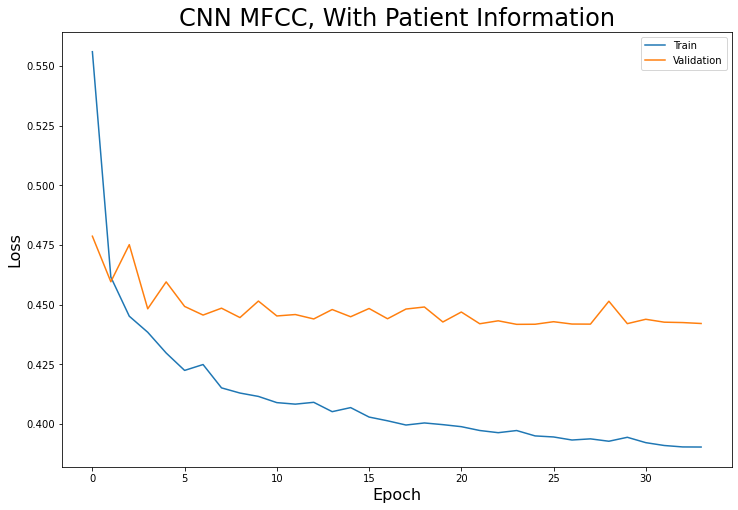

In [18]:
graph_model_loss('CNN MFCC, With Patient Information', history)

In [19]:
#saving model
model.save('/Users/jmd/Documents/BOOTCAMP/Capstone/neural_nets/CNN_MFCCs_with_patient', overwrite=True)

2022-04-01 17:11:40.716540: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/jmd/Documents/BOOTCAMP/Capstone/neural_nets/CNN_MFCCs_with_patient/assets
